# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin & Dr. Luca Pasa
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). We will define a Variational Autoencoder starting from basic PyTorch components. Then, we will define a training loop which includes the two losses used to train VAEs, namely the reconstruction loss and the KL-divergence loss.
Using this training loop, we will fit the model on the MNIST dataset choosing  appropriate hyperparameters. Finally, we will and explore and analyze the latent encodings learned by the model thanks to some visualization techniques.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime type* at the bottom of the page, and then select the GPU hardware accelerator.


#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━

#Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Loading and Preprocessing

We load the MNIST dataset. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits. We chose to use a 128-dimensional batch in order to make the training process reasonably fast -- you should thus leave this value unchanged.

In [4]:
Trns = transforms.ToTensor()
def preprocess(img):
  img = Trns(img)
  H, W = img.shape[1:]
  img = img.reshape((H*W, ))
  return img

MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=preprocess)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
batch_size = 128
dataloader = DataLoader(MNIST, batch_size=batch_size, shuffle=True)

Let us see one of the digits:

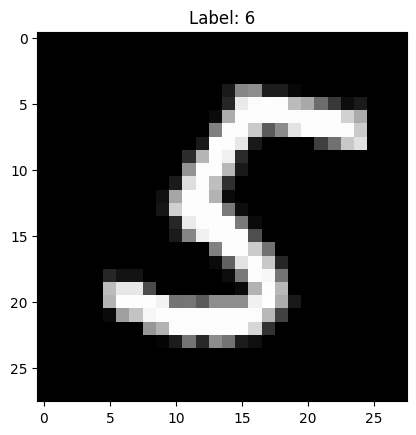

In [6]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

plt.imshow(images[0].reshape(28,28), cmap='gray')
plt.title(f"Label: {labels[0]+1}")
plt.show()

#[TO COMPLETE] VAE Architecture

###Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define two main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.


As usual, we will provide the structure of the implementation of the VAE in PyTorch. The Encoder and Decoder are embodied by the `E_layers` and `D_layers` respectively.<br>

<br>

**[TO COMPLETE]** Complete the code of the VAE model defining:

1. the dense layers that model `z_mean` and `z_var`
2. the sampling function that implements the reparametrization trick
3. the reparameterization trick in the forward function.

*Hint*: to generate random values from a normal distribution you can use the PyTorch [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html) function, and make sure the output shape is the proper one.


`%STARTCODE%`

In [7]:
class VAE(nn.Module):
  def __init__(self, input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun):
    super().__init__()
  
    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.latent_dim = latent_dim

    activation_functions = {'linear':transforms.Lambda(lambda x: x), 'sigmoid':F.sigmoid, 'relu':F.relu, 'tanh': F.tanh, 'leaky_relu': F.leaky_relu}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[act_fun]
    self.last_af = activation_functions[last_layer_act_fun]

    for layer_idx in range(len(ENC_LAYERS)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, ENC_LAYERS[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(ENC_LAYERS[layer_idx-1], ENC_LAYERS[layer_idx]))
    
    ### TO COMPLETE
    # 1. define the dense layers that model z_mean and z_var
    self.linear_mean = nn.Linear(ENC_LAYERS[-1], latent_dim) # [your code here]
    self.linear_var = nn.Linear(ENC_LAYERS[-1], latent_dim)# [your code here]
    ###

    if len(DEC_LAYERS) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(ENC_LAYERS[-1], input_dim))
    else:
      for layer_idx in range(len(DEC_LAYERS)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(latent_dim, DEC_LAYERS[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(DEC_LAYERS[layer_idx-1], DEC_LAYERS[layer_idx]))

    self.final_fc = nn.Linear(DEC_LAYERS[-1], input_dim)
  
  def sampling(self, z_mean, z_var):
    ### TO COMPLETE
    # 2. write the sampling function that implements the reparametrization trick
    z = z_mean + torch.exp(z_var/2) * torch.randn(1).to(device) 
    return z
    ###

  def encode(self, x):
    """This function implmements the encoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.E_layers:
      x = self.af(layer(x))
    return x

  def decode(self, z):
    """This function implmements the decoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.D_layers:
      z = self.af(layer(z))
    
    out = self.final_fc(z)

    return self.last_af(out)
  
  def forward(self, x):
    x = self.encode(x)

    ### TO COMPLETE
    # 3. use the linear layers and the sampling function you defined above
    # to compute the sample z
    # [your code here]
    z_mean = self.linear_mean(x)
    z_var = self.linear_var(x)
    self.z = self.sampling(z_mean, z_var) # [your code here]
    ###

    return self.decode(self.z)

`%ENDCODE%`



#[TO COMPLETE] Loss Functions

Now we have defined the VAE but, since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the _Kullback-Liebler Divergence_. On the other hand, for the reconstruction loss we will use the _binary cross-entropy_ to compare each feature of a data point to the value in the reconstructed output.

**[TO COMPLETE]**: Implement the reconstruction loss and the KL-divergence.

*Disclaimer*: To implement the reconstruction loss you can use function or classes already available in PyTorch, while you must implement the KL-divergence from scratch, explointing the attributes in the `VAE` class.

`%STARTCODE%`

In [8]:
#let's define the reconstruction loss...
REC_LOSS = nn.BCELoss() ### TO COMPLETE 

#..and the Kullback-Liebler Divergence
def KL_LOSS(model):
  ### TO COMPLETE
  mu = model.linear_mean.weight
  sigma = model.linear_var.weight
  loss = -0.5 * (1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2).sum()
  return loss
  ###

`%ENDCODE%`

#[TO COMPLETE] Training

We define the training loop. Notice how we set a $\beta$ parameter to weight the combination of the two losses. 

In [9]:
def train(model, optimizer, dataloader, epochs, Beta=1e-3):
  loss_train_rec, loss_train_kl, loss_train = [], [], []

  for epoch in range(epochs):
    model.train()
    n_train_batches, rec_train, kl_train, total_loss_train = 0, 0, 0, 0

    for idx, (img, _) in enumerate(dataloader):
      # reset the gradient for all parameters
      optimizer.zero_grad()
      
      # move the input to currently used device
      img = img.to(device)

      # run the model
      rec_img = model(img)
      
      # compute the loss for this sample
      rec_loss = REC_LOSS(rec_img, img)
      kl_loss = KL_LOSS(model)
      total_loss = rec_loss + Beta * kl_loss

      # accumulate the loss for this epoch
      total_loss_train += total_loss
      rec_train += rec_loss
      kl_train += kl_loss

      # compute the gradients and update weights
      total_loss.backward()
      optimizer.step()

      n_train_batches += 1

    # compute losses for this epoch
    avg_loss_train = total_loss_train/n_train_batches
    avg_rec_loss_train = rec_train/n_train_batches
    avg_kl_loss_train = kl_train/n_train_batches

    # store losses
    loss_train.append(avg_loss_train.item())
    loss_train_rec.append(avg_rec_loss_train.item())
    loss_train_kl.append(avg_kl_loss_train.item())

    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}", end=' ----- ')
      print(f"Rec Loss: {avg_rec_loss_train:.8f}", end=' ----- ')
      print(f"Effective KL Loss: {Beta * avg_kl_loss_train:.8f}")

  return loss_train, loss_train_rec, loss_train_kl

In [10]:
def plot_losses(loss_train, loss_rec, loss_kl):
  plt.subplot(2, 1, 1)
  plt.grid(True)
  plt.title("Reconstruction Loss")
  plt.plot(loss_rec)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  print("\n")

  plt.subplot(2, 1, 2)
  plt.title("KL Loss")
  plt.grid(True)
  plt.plot(loss_kl)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

**[TO COMPLETE]:** 
Your task is to make the VAE working well and learn the digits'representstions. Define the hyperparameters for the encoder and decoder layers. Explain choice for what concerns the number of layers, the layers sizes, and the activation functions in the cells below.

_Hint:_ Note that we should define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.
Pay attention to the relation between the decoding and encoding layers.

`%STARTCODE%`

In [11]:
### TO COMPLETE
# ENC_LAYERS and DEC_LAYERS should be lists describing the number and size of 
# encoding / decoding layers
input_dim = images.shape[-1] ###TO COMPLETE
ENC_LAYERS =  [512, 256] ###TO COMPLETE
latent_dim = 2
DEC_LAYERS =  [256, 512] ###TO COMPLETE
act_fun =  "relu"###TO COMPLETE
last_layer_act_fun =  "sigmoid"###TO COMPLETE
###

vae = VAE(input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun).to(device)
summary(vae, input_size=(input_dim, ))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [784]                     --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512]                     401,920
│    └─Linear: 2-2                       [256]                     131,328
├─Linear: 1-2                            [2]                       514
├─Linear: 1-3                            [2]                       514
├─ModuleList: 1-4                        --                        --
│    └─Linear: 2-3                       [256]                     768
│    └─Linear: 2-4                       [512]                     131,584
├─Linear: 1-5                            [784]                     402,192
Total params: 1,068,820
Trainable params: 1,068,820
Non-trainable params: 0
Total mult-adds (M): 622.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 4.28
Estimated Total

Let's train out model:

In [12]:
lr = 1e-3
epochs = 30

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [13]:
start = timer()
loss_train, loss_rec, loss_kl = train(vae, optimizer, dataloader, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.98675585 ----- Rec Loss: 0.22871372 ----- Effective KL Loss: 0.75804257
epoch: 2 -> Loss: 0.53256965 ----- Rec Loss: 0.19274104 ----- Effective KL Loss: 0.33982864
epoch: 3 -> Loss: 0.37266472 ----- Rec Loss: 0.18569590 ----- Effective KL Loss: 0.18696876
epoch: 4 -> Loss: 0.28682029 ----- Rec Loss: 0.18185650 ----- Effective KL Loss: 0.10496408
epoch: 5 -> Loss: 0.23761040 ----- Rec Loss: 0.17919929 ----- Effective KL Loss: 0.05841093
epoch: 6 -> Loss: 0.20931667 ----- Rec Loss: 0.17714640 ----- Effective KL Loss: 0.03217018
epoch: 7 -> Loss: 0.19325978 ----- Rec Loss: 0.17546177 ----- Effective KL Loss: 0.01779794
epoch: 8 -> Loss: 0.18408373 ----- Rec Loss: 0.17394982 ----- Effective KL Loss: 0.01013388
epoch: 9 -> Loss: 0.17892249 ----- Rec Loss: 0.17284040 ----- Effective KL Loss: 0.00608207
epoch: 10 -> Loss: 0.17597908 ----- Rec Loss: 0.17206469 ----- Effective KL Loss: 0.00391443
epoch: 11 -> Loss: 0.17367795 ----- Rec Loss: 0.17098807 ----- Effective KL Los

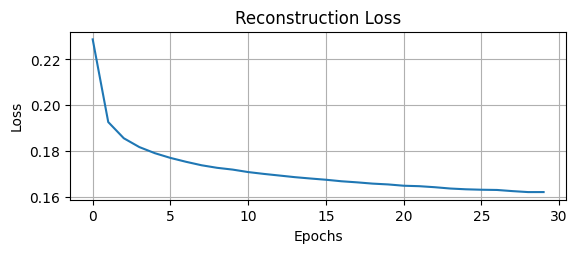

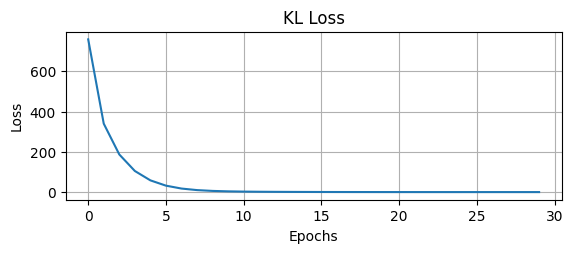

In [14]:
plot_losses(loss_train, loss_rec, loss_kl)

`%ENDCODE%`

`%STARTEXT`

**[TO COMPLETE]** Comment on your choice of number of layers, the layers sizes, and the activation functions.

Answer: To construct the encoder and decoder for this task, I followed a two-layer architecture with a conservative number of neurons in each layer that was near the dimensions of the inputs. Thus, I set enc_layer = [512, 256] and dec_layer = [256, 512]. Regarding activation functions, I used ReLU for all hidden layers and sigmoid for the output layer. In the case of ReLU, it is a popular choice for hidden layers because it is computationally efficient and has been shown to work well in practice. As to the sigmoid, it is a good choice for the output layer because it maps the output to a probability distribution between 0 and 1.


`%ENDTEXT`

#[TO COMPLETE] Generation

The best part about generative models is that they can generate new data (ChatGPT is pretty good at it 🙃). We can therefore plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

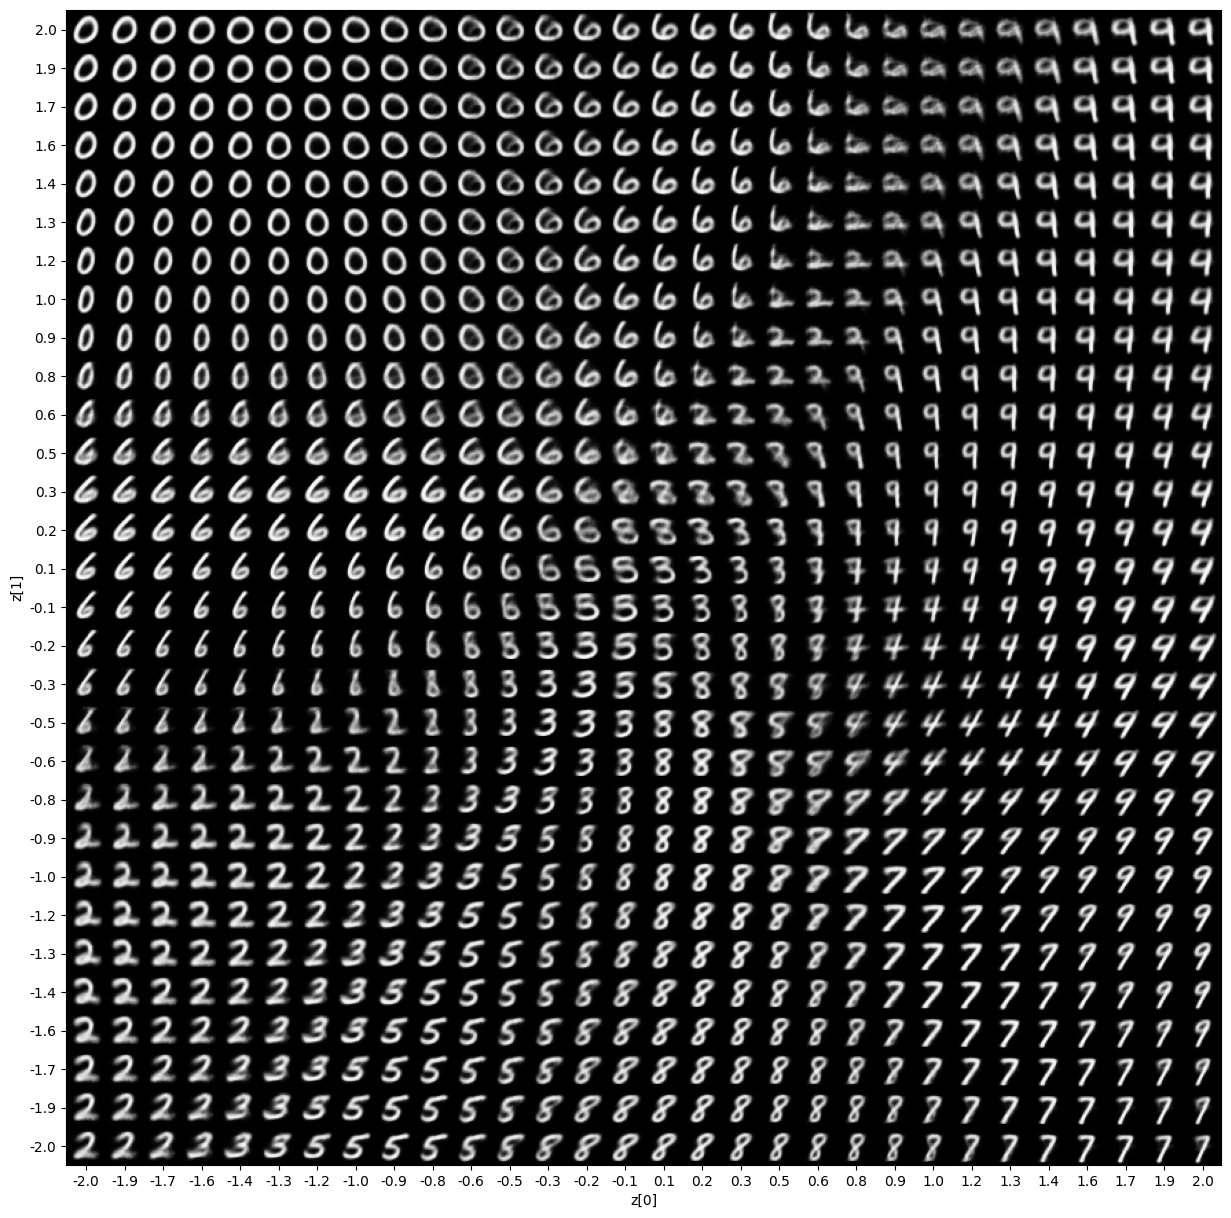

In [22]:
def plot_latent(decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    # here we systematically generate 2D samples of z_hat...
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # ...we cast and reshape the samples
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            # ...and then we pass them to the decoder, 
            # without keeping track of the gradient
            with torch.no_grad():
              x_decoded = vae.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size).to('cpu')
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    # Finally we plot the generated data
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(vae.D_layers, 2.0, 30) 

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

In [23]:
x_train, y_train = next(iter(DataLoader(MNIST, batch_size=len(MNIST))))

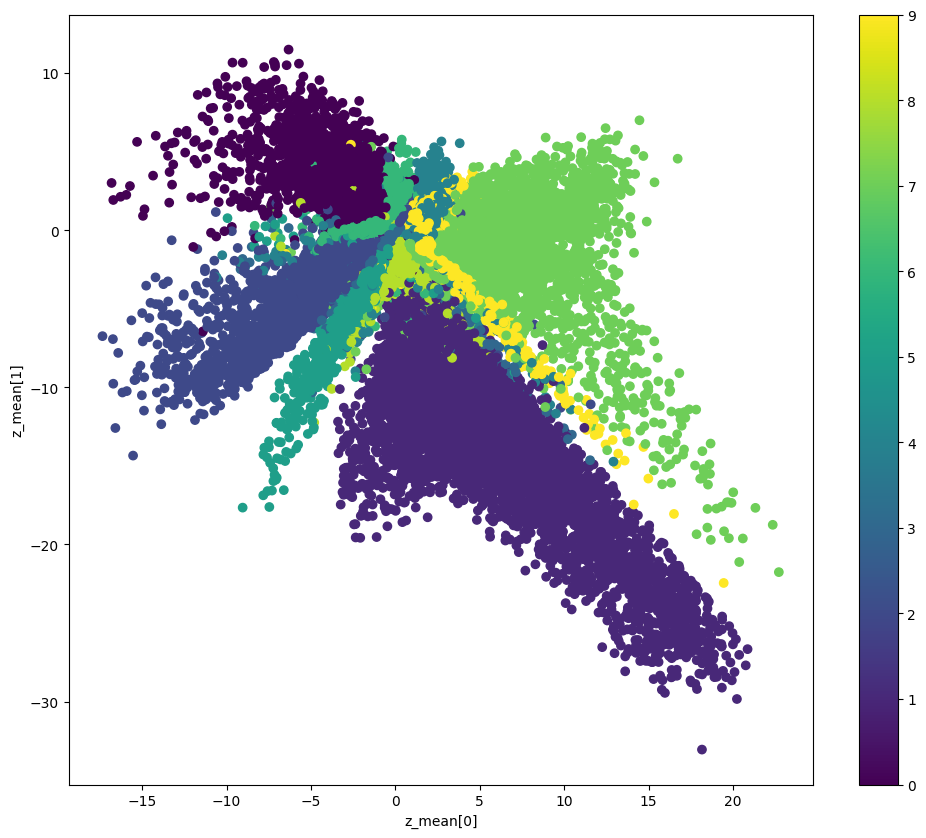

In [24]:
def plot_label_clusters(data, labels):
    with torch.no_grad():
      # let's compute the encodings 
      encoding = vae.encode(data.to(device))
      # and then the mean used in the reparameterization trick
      z_mean = vae.linear_mean(encoding).to('cpu')
    
    # Let's plot the latent space
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z_mean[0]")
    plt.ylabel("z_mean[1]")
    plt.show()

plot_label_clusters(x_train, y_train)

**[TO COMPLETE]** Explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Discuss the obtained plots, and different hyperparameters you have tried. Insert your discussion below:

`%STARTEXT`

Answer: For this task, I tried three more configurations which I describe in the following:

- Base configuration: 
      input_dim = images.shape[-1]
      ENC_LAYERS =  [512, 256]
      latent_dim = 2
      DEC_LAYERS =  [256, 512]
      act_fun =  "relu"
      last_layer_act_fun =  "sigmoid"

- Changing act_fun to sigmoid:
      input_dim = images.shape[-1]
      ENC_LAYERS =  [512, 256]
      latent_dim = 2
      DEC_LAYERS =  [256, 512]
      act_fun =  "sigmoid"
      last_layer_act_fun =  "sigmoid"
In this case, using sigmoid as activation function increases the reconstruction and KL losses, producing more areas in the graph where the examples overlap

- Increasing the number of layers of the encoder:
      input_dim = images.shape[-1]
      ENC_LAYERS =  [512, 256, 128]
      latent_dim = 2
      DEC_LAYERS =  [128, 256, 512]
      act_fun =  "relu"
      last_layer_act_fun =  "sigmoid"
By increasing the number of layers to three, it increases the reconstruction loss and decreases the KL loss. The effect in the last graph seems to indicate that still the base configuration produces better defined clusters.

- Reducing the number of neurons in de encoder layers:
      input_dim = images.shape[-1]
      ENC_LAYERS =  [64, 32]
      latent_dim = 2
      DEC_LAYERS =  [32, 64]
      act_fun =  "relu"
      last_layer_act_fun =  "sigmoid"
For this case, there is an increase in both losses, probably due to the huge dimensionality reduction. As a result, the last plot shows a major overlap between the classes

`%ENDTEXT`